In [2]:
pip install jsmetrics

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install cartopy

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install h5netcdf 

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install netcdf4

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install cartopy

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install xarray

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install cftime

Note: you may need to restart the kernel to use updated packages.


In [9]:
import xarray as xr
import numpy as np
import cftime
import jsmetrics
import jsmetrics.metrics.jet_statistics as jet_statistics
import matplotlib.pyplot as plt
import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import math
from collections import Counter
import pandas as pd

In [10]:
# Función para mapear contourf con contour
def contour(data,contourdata,levels=np.arange(0,11),ccmap='PuBu',extend='max',limite_NS=42,clevels=np.arange(230,300,15),titulo='OLR y pr',cbarlabel='pr  [mm day$^{-1}$]'):
    lons,lats=data.lon,data.lat
    data, lon = add_cyclic_point(data, coord=lons)
    contourdata, lon = add_cyclic_point(contourdata, coord=lons)
    fig = plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.Robinson())
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    cs=ax.contourf(lon,lats,data,levels=levels,cmap=ccmap,extend=extend,transform=ccrs.PlateCarree(),alpha=0.9)
    cc=ax.contour(lon,lats,contourdata,levels=clevels,colors='k',transform=ccrs.PlateCarree())
    ax.clabel(cc, cc.levels, inline=True, fontsize=10)
    ax.set_extent([-180,180, -limite_NS, limite_NS], crs=ccrs.PlateCarree())
    gl=ax.gridlines(draw_labels=True,color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = True
    gl.xlabel_style = {'size': 13}
    gl.ylabel_style = {'size': 13}
    plt.title(titulo,fontsize=13)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    cbar=plt.colorbar(cs,orientation='horizontal',fraction=0.046, pad=0.06)
    cbar.ax.set_xlabel(cbarlabel)

In [11]:
def lineplot_setup(xmin,xmax,xlab,ylab,ymin=None,ymax=None,title=None,legend=False):
    # especificar limites minimos y maximos del grafico
    plt.xlim([xmin,xmax])
    plt.ylim([ymin,ymax])
    # cuadrilla interna del grafico
    plt.grid(linestyle='--',alpha=0.66)
    plt.minorticks_on()
    # hacer las etiquetas de ambos ejes mas grandes
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.xlabel(xlab,fontsize=10)
    plt.ylabel(ylab,fontsize=10)
    plt.title(title,fontsize=11)
    if legend:
        plt.legend(fancybox=True,shadow=True,fontsize=8)


<a name='title'></a>
 **<font color="Purple"> Funciones </font>**
---

###### 1. Primer paso es subir los archivos 
###### 2. Abrir archivos y seleccionar variables a usar


In [12]:
#Seleccionar archivos del historical
u_filename='ua_Amon_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_195001-201412.nc'
v_filename='va_Amon_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_195001-201412.nc'

In [13]:
# Seleccionar variables del archivo historical
u_ds=xr.open_dataset(u_filename)
ua=u_ds['ua']  #viento zonal
v_ds=xr.open_dataset(v_filename)
va=v_ds['va']  #viento meridional

In [14]:
# Seleccionar archivos del ssp585
u_filename585 = 'ua_Amon_HadGEM3-GC31-LL_ssp585_r1i1p1f3_gn_205001-210012.nc'
v_filename585='va_Amon_HadGEM3-GC31-LL_ssp585_r1i1p1f3_gn_205001-210012.nc'

In [15]:
# Seleccionar variables del archivo ssp585
u_ds585=xr.open_dataset(u_filename585)
ua585=u_ds585['ua']
v_ds585=xr.open_dataset(v_filename585)
va585=v_ds585['va']

In [16]:
tas_file = 'tas_day_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_19500101-20141230.nc'

In [17]:
tas_ds=xr.open_dataset(tas_file)
tas=tas_ds['tas']
tas=tas-273.15

In [18]:
lats=tas.lat
lons=tas.lon

###### <h1  style="color:rebeccapurple; font-size:17px;"><i> Estadística </i> </h1>
#####   - `Anual` y `en una región`



In [19]:
def recortes (ua1,va1,ua2,va2,latA,latB,lonA,lonB,año1,año2):
    """
    Esta función nos recortará los datos (años,latitudes, longitudes) para usarlos en otras funciones 
    ua1,va1: viento (zonal,meridional) de la simulación 1 
    ua2,va2:  viento (zonal,meridional) de la simulación 2
    latA,latB: recorte de latitudes de menor (A) a mayor (B)
    lonA,lonB: recorte de longitudes de menor (A) a mayor (B)
    """
    ua1["plev"]=ua1["plev"]/100
    ua2["plev"]=ua2["plev"]/100

    ua1['units']='hPa'
    ua2['units']='hPa'

    ua1 = ua1.sel(lat=slice(latA, latB), lon=slice(360-lonB, 360-lonA)).where(ua1.time.dt.year > año1, drop=True)
    va1 = va1.sel(lat=slice(latA, latB), lon=slice(360-lonB, 360-lonA)).where(va1.time.dt.year > año1, drop=True)
    
    ua2 = ua2.sel(lat=slice(latA, latB), lon=slice(360-lonB, 360-lonA)).where(ua2.time.dt.year > año2, drop=True)
    va2 = va2.sel(lat=slice(latA, latB), lon=slice(360-lonB, 360-lonA)).where(va2.time.dt.year > año2, drop=True)
    
    #Recorte para la temporada invernal en el HN
    
    ua1=ua1.where((ua1.time.dt.month==12)| (ua1.time.dt.month==1)| (ua1.time.dt.month==2),drop=True)
    va1=va1.where((va.time.dt.month==12)| (va1.time.dt.month==1)| (va1.time.dt.month==2),drop=True)

    ua2=ua2.where((ua2.time.dt.month==12)| (ua2.time.dt.month==1)| (ua2.time.dt.month==2),drop=True)
    va2=va2.where((va2.time.dt.month==12)| (va2.time.dt.month==1)| (va2.time.dt.month==2),drop=True)
    
    return {'ua1': ua1, 'va1': va1, 'ua2': ua2, 'va2': va2}

In [20]:
def js_pos_intens (ua1,ua2,nivel):
    """
    Esta función encuentra la posición promedio y la intensidad, usando el método de Woollings et al. 2010
    ua1: Viento zonal de la simulación 1 (ua1)
    ua2: Viento zonal de la simulación 2 (ua2)
    nivel: a qué nivel de presión se hará el cálculo, en Pa
    
    """
    
    #Convertir el tiempo a gregoriano 
    ua1 = ua1.convert_calendar(calendar='gregorian', align_on='year')
    ua2 = ua2.convert_calendar(calendar='gregorian', align_on='year')
    
    #Usamos jsmetrics statistics
    sim1 = jsmetrics.jet_statistics.woollings_et_al_2010(ua1.sel(plev=nivel),filter_freq=4,window_size=20)

    sim2 = jsmetrics.jet_statistics.woollings_et_al_2010(ua2.sel(plev=nivel),filter_freq=4,window_size=20)
    
    #POSICIÓN
    sim1_p=sim1["jet_lat"].groupby(sim1["jet_lat"].time.dt.year).mean() 
    sim2_p=sim2["jet_lat"].groupby(sim2["jet_lat"].time.dt.year).mean()  
    
    #VELOCIDAD
    sim1_v=sim1["jet_speed"].groupby(sim1["jet_speed"].time.dt.year).mean()  
    sim2_v=sim2["jet_speed"].groupby(sim2["jet_speed"].time.dt.year).mean() 
    
    return {'Posición del jet en simulación 1':sim1_p,
            'Posición del jet en simulación 2':sim2_p,
            'Velocidad del jet en simulación 1':sim1_v,
            'Velocidad del jet en simulación 2':sim2_v,
            }

In [21]:
#recortes tiene argumentos(ua1,va1,ua2,va2,latA,latB,lonA,lonB,año1,año2)
recorteR = recortes(ua,va,ua585,va585,10,40,67,129,1978,2069)
recorteR #ya está en hPa

{'ua1': <xarray.DataArray 'ua' (time: 108, plev: 19, lat: 25, lon: 33)> Size: 7MB
 array([[[[-1.00373535e+01, -9.73950195e+00, -9.45703125e+00, ...,
                       nan,             nan,             nan],
          [-1.00344238e+01, -9.67944336e+00, -9.34082031e+00, ...,
                       nan, -6.15234375e+00, -6.62220001e+00],
          [-9.91845703e+00, -9.52490234e+00, -9.09814453e+00, ...,
           -1.27614746e+01, -1.15314941e+01, -1.08188477e+01],
          ...,
          [ 6.01928711e+00,  5.64526367e+00,  1.91546941e+00, ...,
            6.09346724e+00,  6.99245453e+00,  7.90395832e+00],
          [ 6.64721680e+00,  5.02099609e+00, -3.89826059e-01, ...,
            4.73524714e+00,  5.76099634e+00,  6.87148857e+00],
          [ 7.00073242e+00,  3.13875008e+00,             nan, ...,
            2.97003508e+00,  3.86788988e+00,  5.29230022e+00]],
 
         [[-1.13398438e+01, -1.10424805e+01, -1.06806641e+01, ...,
           -2.84545898e+00, -3.43579102e+00, -5.54199

In [35]:
#js_pos_intens tiene argumentos (ua1,ua2,nivel) NIVEL ESTÁ EN hPa o en Pa???
POS_VEL = js_pos_intens(recorteR['ua1'], recorteR['ua2'],200)
POS_VEL

{'Posición del jet en simulación 1': <xarray.DataArray 'jet_lat' (year: 36)> Size: 288B
 array([35.41666667, 30.41666667, 35.        , 32.08333333, 32.5       ,
        31.66666667, 30.41666667, 29.58333333, 32.91666667, 32.5       ,
        32.08333333, 32.5       , 30.83333333, 28.75      , 30.        ,
        33.33333333, 30.        , 30.        , 31.66666667, 32.08333333,
        31.25      , 32.91666667, 32.5       , 31.25      , 33.75      ,
        30.        , 35.41666667, 31.25      , 32.91666667, 36.25      ,
        31.66666667, 32.08333333, 28.33333333, 32.5       , 35.        ,
        31.25      ])
 Coordinates:
     plev     float64 8B 200.0
     units    <U3 12B 'hPa'
   * year     (year) int64 288B 1979 1980 1981 1982 1983 ... 2011 2012 2013 2014,
 'Posición del jet en simulación 2': <xarray.DataArray 'jet_lat' (year: 31)> Size: 248B
 array([30.        , 31.66666667, 33.75      , 30.        , 30.83333333,
        30.41666667, 28.75      , 35.        , 29.58333333, 27.

In [36]:
#Seleccionar el periodo de 1979 a 2014
tas79 = tas.where(tas.time.dt.year >= 1979, drop=True)

In [37]:
#datos solo de invierno (de los 36 años)
tas_inviernos = tas79.sel(time=tas79['time.month'].isin([12, 1, 2]))

In [38]:
def CAOS_MX_jlgf(Tdias):
    """
    Esta función identifica los días cuando se cumple la condición de CAO (Cold Air Outbreak)
    y devuelve las fechas correspondientes en un calendario estándar.
    
    Parámetros:
    - Tdias (xarray.DataArray): Temperatura diaria en invierno durante ~30 años.
    
    Retorna:
    - lista de fechas
    - medidas de frecuencia de caos.
    - temperatura
    """
    mean = Tdias.mean()
    desv_est = Tdias.std()
    condicionCAO = mean - 2 * desv_est  
    dias_CAO = []
    temp_list = []
    print(condicionCAO)
    #return
    for i in range(len(Tdias) - 1):
        if Tdias[i] < condicionCAO and Tdias[i + 1] < condicionCAO:
            dias_CAO.append(i)
            dias_CAO.append(i + 1)
            dias_CAOS = pd.DataFrame(dias_CAO).drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)
    
    # Obtener las fechas correspondientes usando los índices
    dias_CAO_dates = Tdias['time'].values[dias_CAO]

    # Convertir las fechas a un calendario gregoriano estándar 
    fechas_CAO_datetime = pd.to_datetime([str(date) for date in dias_CAO_dates],errors='coerce')    
    fechas_indices = {fecha: dias_CAO[i] for i, fecha in enumerate(fechas_CAO_datetime)}
    
    # Imprimir las fechas y sus índices
    for fecha, indice in fechas_indices.items():
        temperatura = Tdias[indice].values 
        temp_list.append(temperatura)
     #   print(f"Índice: {indice}, Fecha: {fecha}, Temperatura: {temperatura}")
    
    #print(pd.DataFrame(dias_CAO).drop_duplicates().size)
    #print(len(fechas_CAO_datetime),len(dias_CAO),len(dias_CAO_dates))
    promedioT=np.mean(temp_list)
    
    dicc={'fechas':fechas_indices,'temperaturas':temp_list,'freq':len(dias_CAOS)/36,'promedioT':promedioT}
    
    return dicc

In [39]:
latitudes = tas_inviernos.sel(lat=slice(22,27))
longitudes = latitudes.sel(lon=slice(255,262))

In [40]:
weights = np.cos(np.deg2rad(longitudes))
weights.name = "weights"

In [41]:
tas_weighted = longitudes.weighted(weights)

In [42]:
weights # no entiendo qué hace esto

<xarray.DataArray 'weights' (time: 3240, lat: 4, lon: 4)> Size: 207kB
array([[[0.9871605 , 0.99271417, 0.9762576 , 0.954101  ],
        [0.9936825 , 0.988893  , 0.9688684 , 0.960655  ],
        [0.9886951 , 0.98045164, 0.9695055 , 0.96517336],
        [0.98676896, 0.9795889 , 0.96536595, 0.96647877]],

       [[0.9884575 , 0.9963707 , 0.9846671 , 0.95895684],
        [0.9948121 , 0.99226385, 0.9829956 , 0.96631116],
        [0.99618965, 0.99028724, 0.9799267 , 0.9727559 ],
        [0.9926018 , 0.9862753 , 0.97982293, 0.97792053]],

       [[0.98690814, 0.9914117 , 0.97805125, 0.95196015],
        [0.9930265 , 0.9867482 , 0.97502005, 0.9588649 ],
        [0.9927116 , 0.98193353, 0.9685829 , 0.96593064],
        [0.9870295 , 0.9753502 , 0.97091246, 0.97059226]],

       ...,

       [[0.98401517, 0.9897723 , 0.976168  , 0.94495726],
        [0.9880564 , 0.9860883 , 0.9749746 , 0.9629939 ],
        [0.9883287 , 0.9855217 , 0.9765603 , 0.97187674],
        [0.9881259 , 0.98193276, 0.9710266 , 0.9772269 ]],

       [[0.9833746 , 0.99102575, 0.97647864, 0.9528434 ],
        [0.98787254, 0.98952407, 0.9764483 , 0.9690969 ],
        [0.98800516, 0.9871911 , 0.9793079 , 0.96885365],
        [0.98904693, 0.9882552 , 0.98033327, 0.9781515 ]],

       [[0.9841084 , 0.99183106, 0.9726966 , 0.9386835 ],
        [0.988867  , 0.99033755, 0.96791506, 0.9507022 ],
        [0.9902932 , 0.9852188 , 0.96797925, 0.959121  ],
        [0.98918736, 0.98661023, 0.9760402 , 0.9678476 ]]], dtype=float32)
Coordinates:
  * time     (time) object 26kB 1979-01-01 12:00:00 ... 2014-12-30 12:00:00
  * lat      (lat) float64 32B 23.12 24.38 25.62 26.88
  * lon      (lon) float64 32B 255.9 257.8 259.7 261.6
    height   float64 8B 1.5

In [43]:
norte = tas_weighted.mean(['lon','lat']) #promedio a variable ya pesada
norte #ya lo puedo meter en función de CAO, no'?

<xarray.DataArray 'tas' (time: 3240)> Size: 13kB
array([11.943233,  9.749307, 11.778044, ..., 11.680151, 11.034022,
       12.069647], dtype=float32)
Coordinates:
  * time     (time) object 26kB 1979-01-01 12:00:00 ... 2014-12-30 12:00:00
    height   float64 8B 1.5

In [48]:
def CAO_años(resultados_fxCAO,año1,año2):
    resultados_fxCAO = CAOS_MX_jlgf(norte)  
    
    # Extraer las fechas de los eventos CAO
    fechas_CAO = list(resultados_fxCAO['fechas'].keys())
    
    # Convertir las fechas en un formato adecuado
    fechas_df = pd.to_datetime(fechas_CAO)
    
    # Extraer los años de las fechas
    años = fechas_df.year
    
    # Contar cuántas veces se repite cada año
    conteo_años = Counter(años)
    
    # Crear un rango de años de 1979 a 2014
    rango_años = range(año1, año2)
    
    # Asegurarnos de que todos los años del rango tengan un valor, aunque sea 0
    conteo_completo = {año: conteo_años.get(año, 0) for año in rango_años}
    
    # Preparar los datos para graficar
    años_unicos = list(conteo_completo.keys())
    cantidad_eventos = list(conteo_completo.values())
    
    # Crear el gráfico de barras
    plt.figure(figsize=(10, 6))
    plt.scatter(años_unicos, cantidad_eventos, color='b', alpha=0.7)
    
    # Etiquetas y título del gráfico
    lineplot_setup(1978,2015,'Año','Cantidad de eventos CAO',0.5,10,title='Cantidad de CAO por año en el Norte de México (1979-2014)')
    plt.xticks(años_unicos, rotation=45) 
    
    
    plt.tight_layout()  
    plt.show()

<xarray.DataArray 'tas' ()> Size: 8B
array(6.00645685)
Coordinates:
    height   float64 8B 1.5
<xarray.DataArray 'tas' ()> Size: 8B
array(6.00645685)
Coordinates:
    height   float64 8B 1.5


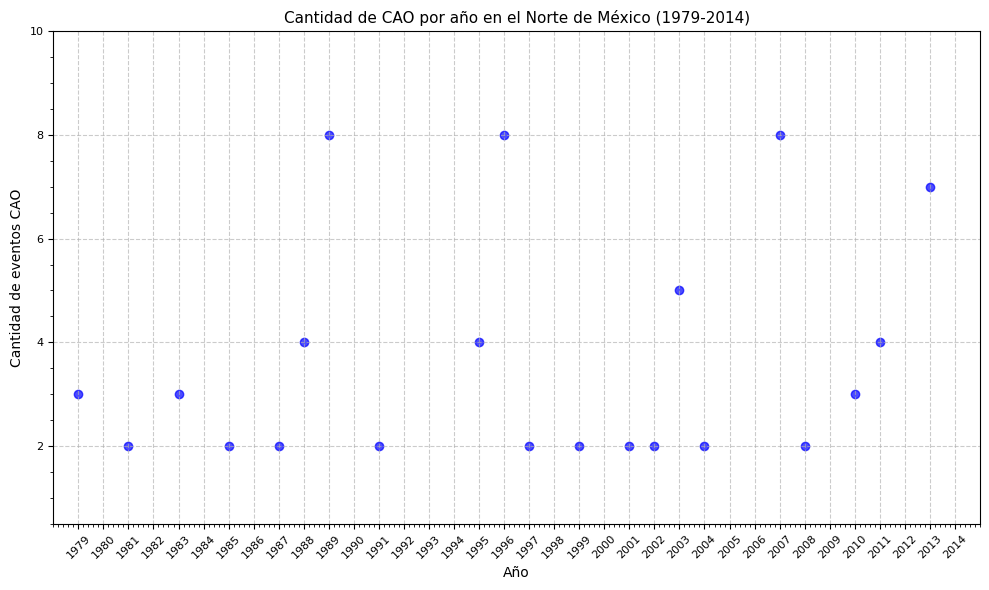

In [49]:
CAO_años(CAOS_MX_jlgf(norte),1979,2015)

In [51]:
def varianza1a1(sim1_p, sim1_v):
    # Varianza de posición
    var_1p = sim1_p.var().round(2)
    mean_1p = sim1_p.round(2)
    
    # Varianza de velocidad
    var_1v = sim1_v.var().round(2)
    mean_1v = sim1_v.round(2)
    
    # Datos para graficar varianza y medias
    graf_mean = [mean_1p, mean_1v]
    graf_var = [var_1p, var_1v]
    colors = ["#FF8F00", "#FF8F00"]
    colorf = ["#AF47D2", "#AF47D2"]
    eje = ["Latitud promedio [°N]", "Velocidad promedio [m/s]"]
    titulo = [
        [input("Nombre de la simulación 1: "), "Posición"],
        [input("Nombre de la simulación 1: "), "Velocidad"]
    ]

    # Crear la figura y los subplots
    fig, axs = plt.subplots(2, 1, figsize=(10, 7), dpi=120)  # 2 filas, 1 columna

    # Iterar para cada gráfico (latitud y velocidad)
    for i, value in enumerate(graf_mean):
        ax = axs[i]
        ax.plot(value.year, value, color=colors[i])
        ax.fill_between(value.year, value + graf_var[i], value - graf_var[i], alpha=0.2, color=colorf[i], label="Varianza")
        ax.set_xlim([value.year.min() - 1, value.year.max() + 1])
        ax.set_xlabel("Años")
        ax.set_ylabel(eje[i])
        ax.set_title(f"{titulo[i][1]} del Jet Subtropical durante \nel invierno boreal sobre el norte de México \n{titulo[i][0]}")
        ax.legend()

    # Ajustar el layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    fig.suptitle("Análisis estadístico del Jet Subtropical\n", fontsize=14, color="red")
    
    # Mostrar el gráfico
    plt.show()
    
    return fig


Nombre de la simulación 1:  Datos históricos (1979 a 2014)
Nombre de la simulación 1:  Datos históricos (1979 a 2014) 


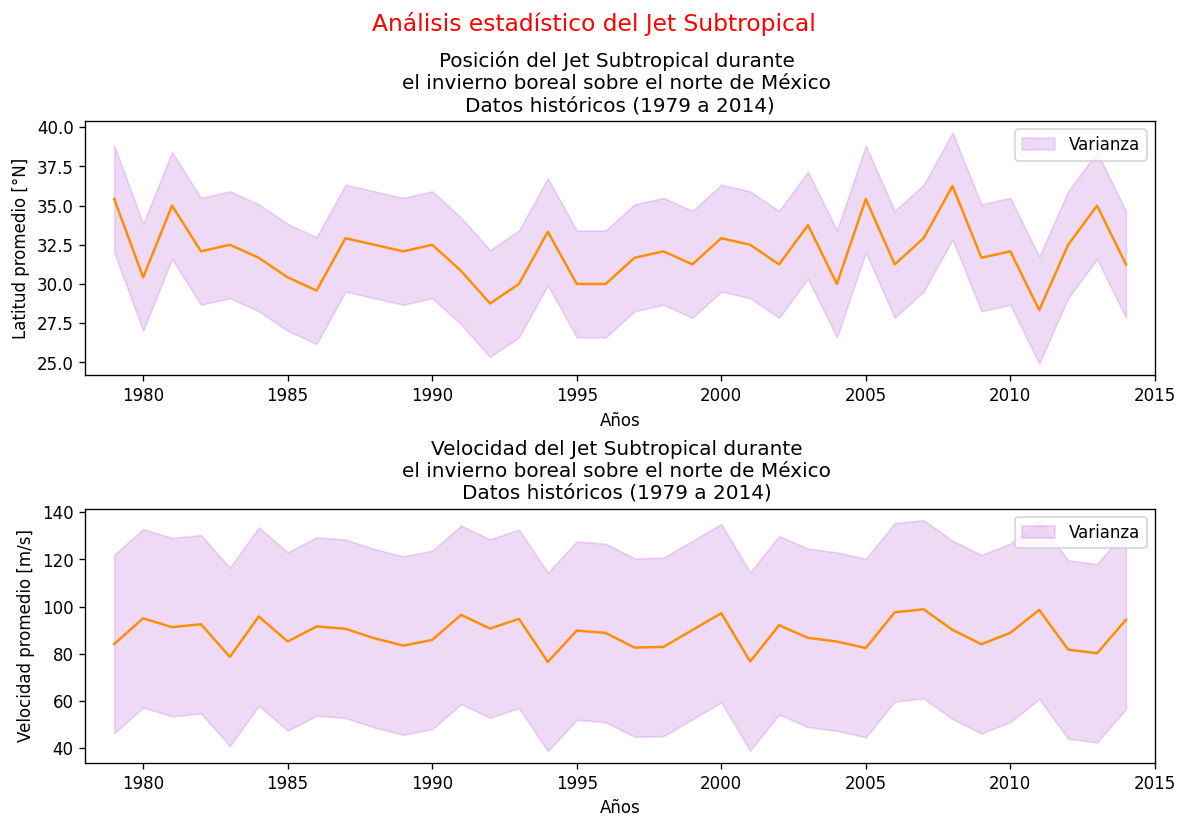

In [52]:
VAR1a1 = varianza1a1(POS_VEL['Posición del jet en simulación 1'],
               POS_VEL['Velocidad del jet en simulación 1'],)

In [64]:
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

def varianza_CAOs(sim1_p, sim1_v, resultados_fxCAO, año1, año2):
    # Varianza de posición y velocidad
    var_1p = sim1_p.var().round(2)
    mean_1p = sim1_p.round(2)
    var_1v = sim1_v.var().round(2)
    mean_1v = sim1_v.round(2)
    
    # Datos para graficar varianza y medias
    graf_mean = [mean_1p, mean_1v]
    graf_var = [var_1p, var_1v]
    colors = ["#FF8F00", "#FF8F00"]
    colorf = ["#AF47D2", "#AF47D2"]
    eje = ["Latitud promedio [°N]", "Velocidad promedio [m/s]"]
    titulo = [
        [input("Nombre de la simulación 1: "), "Posición"],
        [input("Nombre de la simulación 1: "), "Velocidad"]
    ]

    # Crear la figura y los subplots
    fig, axs = plt.subplots(2, 1, figsize=(10, 7), dpi=120)  # 2 filas, 1 columna

    for i in range(2):  # Iterar para cada gráfico (latitud y velocidad)
        ax1 = axs[i]  # Seleccionar el subplot
        ax1.plot(graf_mean[i].year, graf_mean[i], color=colors[i], label=f'{titulo[i][1]} (Media)')
        ax1.fill_between(graf_mean[i].year, graf_mean[i] + graf_var[i], graf_mean[i] - graf_var[i], alpha=0.2, color=colorf[i], label=f'{titulo[i][1]} (Varianza)')
        ax1.set_xlim([mean_1p.year.min() - 1, mean_1p.year.max() + 1])
        ax1.set_xlabel("Años")
        ax1.set_ylabel(eje[i], color=colors[i])
        ax1.tick_params(axis='y', labelcolor=colors[i])
        ax1.set_title(f"{titulo[i][1]} del Jet Subtropical durante \nel invierno boreal sobre el norte de México \n{titulo[i][0]}")
        ax1.legend()

        # Crear el segundo eje Y para los eventos CAO
        ax2 = ax1.twinx()

        # Procesar los eventos CAO
        fechas_CAO = list(resultados_fxCAO['fechas'].keys())
        fechas_df = pd.to_datetime(fechas_CAO)
        años = fechas_df.year
        conteo_años = Counter(años)

        # Crear el rango de años y asegurarse de que todos los años tengan un valor
        rango_años = range(año1, año2)
        conteo_completo = {año: conteo_años.get(año, 0) for año in rango_años}

        # Preparar los datos para graficar
        años_unicos = list(conteo_completo.keys())
        cantidad_eventos = list(conteo_completo.values())

        # Graficar los eventos CAO como scatter en el eje derecho
        ax2.scatter(años_unicos, cantidad_eventos, color='m', alpha=0.7, label="Eventos CAO")
        ax2.set_ylabel("Cantidad de eventos CAO", color='m')
        ax2.tick_params(axis='y', labelcolor='m')

    # Ajustar el layout y mostrar el gráfico
    plt.tight_layout()  
    plt.subplots_adjust(top=0.9)
    fig.suptitle("Análisis estadístico del Jet Subtropical y Eventos CAO\n", fontsize=14, color="red")
    plt.show()

    return fig


<xarray.DataArray 'tas' ()> Size: 8B
array(6.00645685)
Coordinates:
    height   float64 8B 1.5


Nombre de la simulación 1:  Históricos
Nombre de la simulación 1:  Históricos


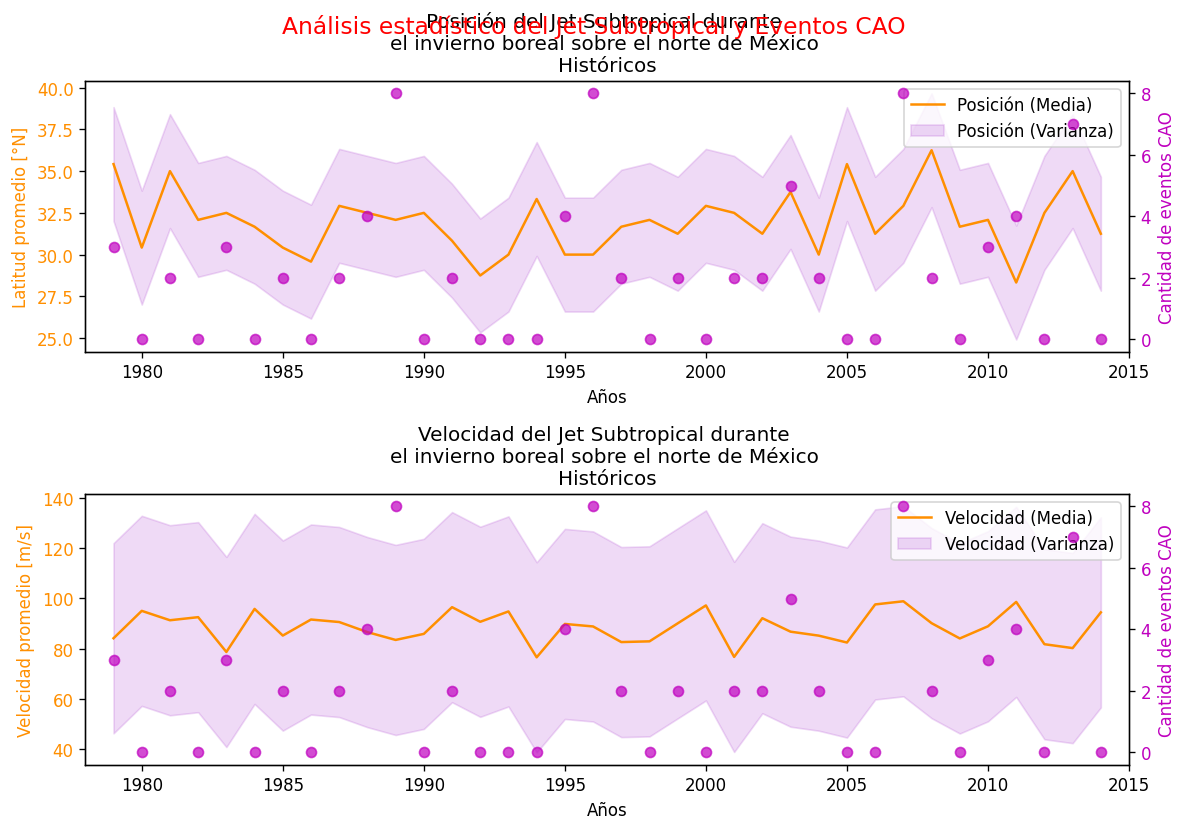

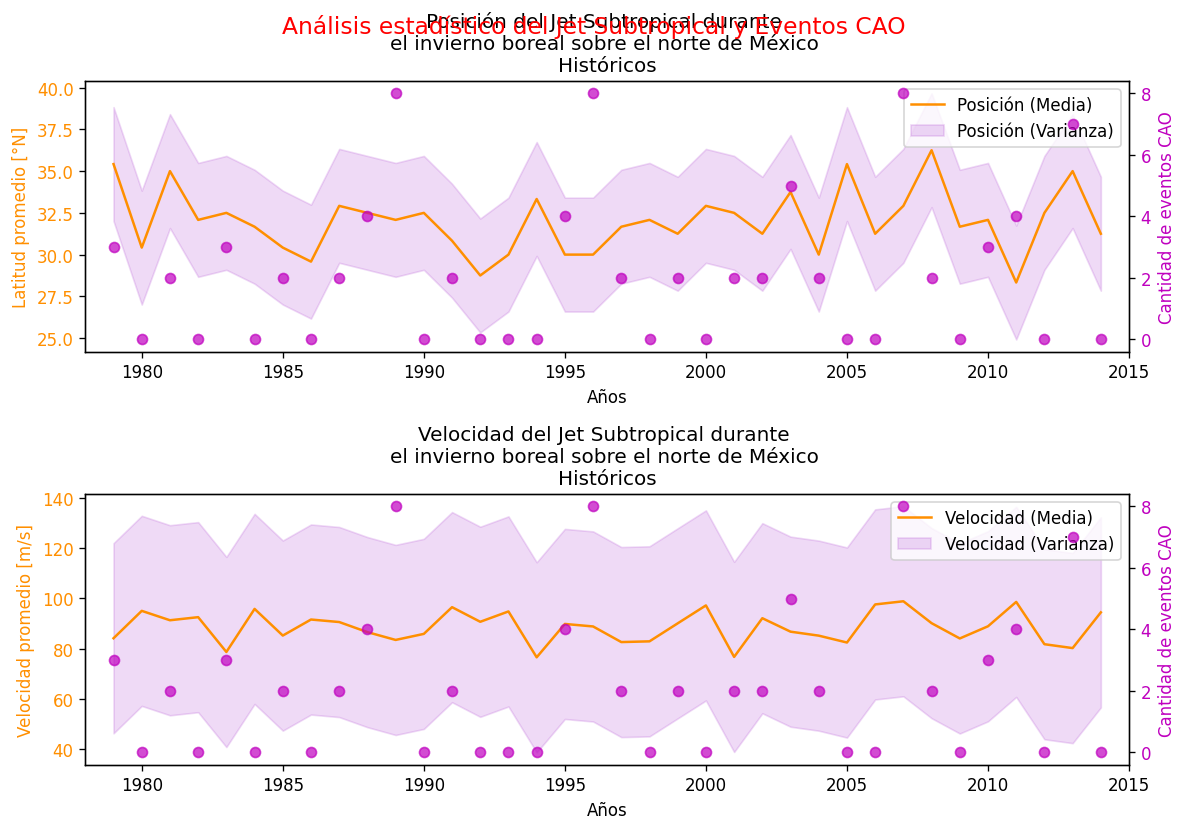

In [65]:
# varianza_CAOs toma argumentos (sim1_p, sim1_v, resultados_fxCAO, año1, año2):
varianza_CAOs(
    POS_VEL['Posición del jet en simulación 1'],  # Posición del jet
    POS_VEL['Velocidad del jet en simulación 1'],  # Velocidad del jet
    CAOS_MX_jlgf(norte),  # Resultados CAO
    1979,  # Año inicial
    2015   # Año final
)

